In [1]:
import os
import sys
from pathlib import Path

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
sys.path.append(str(Path(os.getcwd()).parent))

In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from torch import Tensor

from models.classifier import AmNewsClassifier, load_dataset, SavedModel
from preprocessing.pipeline import PreprocessingPipeline
from tools.load_scraped import load_scraped

In [3]:
data = pd.read_csv("../data/am_news_corpus.csv")

In [4]:
scraped_dataset = load_scraped("../scraped_data/bbc_news.json")
scraped_data = pd.DataFrame(map(lambda x: x.__dict__, scraped_dataset))
scraped_data.count()

title       2334
content     2334
category    2334
dtype: int64

In [5]:
scraped_data.head()

,title,content,category
0,ሪያል ማድሪድ 1 ቢሊዮን ዩሮ ትርፍ በማግኘት የመጀመሪያ ክለብ ሲሆን ዩና...,የስፔኑ ሪያል ማድሪድ አንድ ቢሊዮን ዶላር ዓመታዊ ትርፍ በማጋበስ የመጀመ...,Sports
1,በማንቸስተር ዩናይትድ ታሪክ ደካማው ቡድን ሳይሆን አይቀርም- ሩበን አሞሪም,የማንቸስተር ዩናይትዱ አሰልጣኝ ሩበን አሞሪም ቡድናቸው በክለቡ 147 ዓመ...,Sports
2,"አርሰናል በሜዳው ከቪላ አቻ ቢወጣም አርቴታ ""በልጆቼ ኮርቻለሁ"" አሉ",አርሰናል በሜዳው አስተን ቪላን አስተናግዶ በሁለት ጎል ልዩነት መምራት ቢ...,Sports
3,አርሰናል ከአስተን ቪላ - ማን ይረታል? የፕሪሚዬር ሊግ ጨዋታዎች ግምት,ኒውካስል በታሪኩ ለመጀመሪያ ጊዜ በተከታታይ 10 ጨዋታዎች ድል ሊቀናው ይ...,Sports
4,አርሰናል ከቶተንሀም፡ ማን ያሸንፋል? የፕሪሚዬር ሊግ ጨዋታዎች ግምት,ኖቲንግሀም ፎረስት የዘንድሮው ፕሪሚዬር ሊግ ያልተጠበቀ አስደናቂ ቡድን ሆ...,Sports


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2334 entries, 0 to 2333
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     2334 non-null   object
 1   content   2334 non-null   object
 2   category  2334 non-null   object
dtypes: object(3)
memory usage: 54.8+ KB


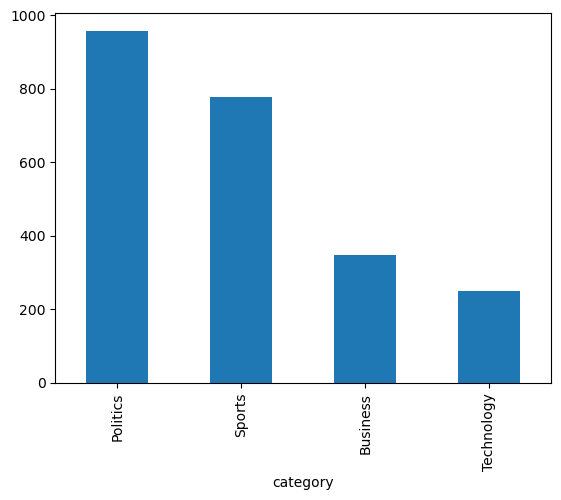

In [6]:
scraped_data["category"].value_counts().plot(kind='bar')
scraped_data.info()

In [7]:
scraped_data = scraped_data.rename(columns={"content": "article"})
scraped_data = scraped_data.drop(columns=["title"])

data = pd.concat([data, scraped_data], axis=0)

In [8]:
preprocess = PreprocessingPipeline()
data = data.dropna()

# Rename entertainment and technology as Others
data['category'] = data['category'].replace(['Entertainment', 'Technology'], 'Others')

data["category_num"] = pd.factorize(data["category"])[0]
data["article"] = data["article"].apply(preprocess)

# shuffle the df
data = data.sample(frac=1, random_state=4).reset_index(drop=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64249 entries, 0 to 64248
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article       64249 non-null  object
 1   category      64249 non-null  object
 2   category_num  64249 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


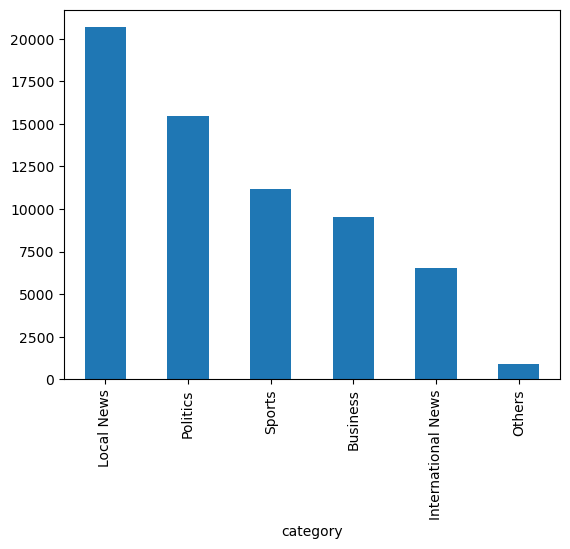

In [9]:
data["category"].value_counts().plot(kind='bar')
data.info()

In [10]:
articles, labels = data["article"], data["category_num"]

In [11]:
train_split = 0.8
split_idx = int(articles.count() * train_split)

articles_train, labels_train = articles[:split_idx], labels[:split_idx]
articles_test, labels_test = articles[split_idx:], labels[split_idx:]

In [12]:
# vectorizer = TfidfVectorizer(analyzer='word', max_features=512, ngram_range=(1, 3))
# vectorizer.fit(articles_train)
# with open("../models/trained/tfidfvectorizer.pkl", "wb") as f:
#     pickle.dump(vectorizer, f)
    
with open("../models/trained/tfidfvectorizer.pkl", "rb") as f:
    vectorizer: TfidfVectorizer = pickle.load(f)

In [13]:
X_train, y_train = vectorizer.transform(articles_train).toarray(), labels_train.array
X_test, y_test = vectorizer.transform(articles_test).toarray(), labels_test.array

In [14]:
# prepare validation dataset from train dataset
val_size = 1000
X_val, y_val = X_train[:val_size], y_train[:val_size]
X_train, y_train = X_train[val_size:], y_train[val_size:]

batch_size = 32
train_loader = load_dataset(X_train, y_train, batch_size=batch_size, shuffle=True)
val_loader = load_dataset(X_val, y_val, batch_size=32)
test_loader = load_dataset(X_test, y_test)

Test accuracy before training: 0.23369650542736053
Train accuracy before training: 0.24220718443393707
Epoch 1 Train Loss: 0.7566534804162525, Val Loss: 0.6235604882240295
Epoch 2 Train Loss: 0.5791263840501271, Val Loss: 0.5871760249137878
Epoch 3 Train Loss: 0.5525573823943971, Val Loss: 0.5815956592559814
Epoch 4 Train Loss: 0.5314581164575758, Val Loss: 0.5655653476715088
Epoch 5 Train Loss: 0.5094132963343272, Val Loss: 0.5555368065834045
Epoch 6 Train Loss: 0.48627117940357756, Val Loss: 0.5152184367179871
Epoch 7 Train Loss: 0.4631675175163481, Val Loss: 0.5193924903869629
Epoch 8 Train Loss: 0.4414542026983367, Val Loss: 0.5111383199691772
Epoch 9 Train Loss: 0.42119498180018533, Val Loss: 0.5045498013496399
Epoch 10 Train Loss: 0.4023415705230501, Val Loss: 0.49156516790390015


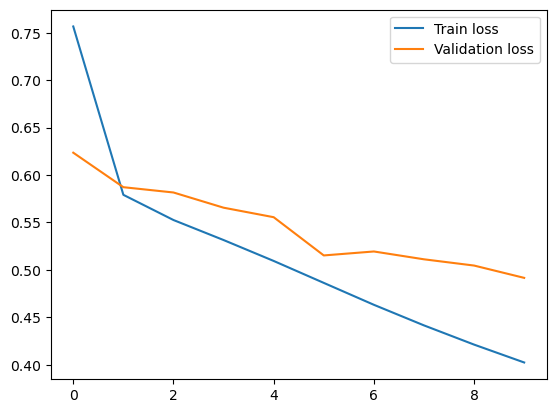

In [16]:
classifier = AmNewsClassifier(
    input_size=512,
    hidden_sizes=[64, 16],
    output_size=6
)

train_accuracy = classifier.evaluate(Tensor(X_train), Tensor(y_train))
test_accuracy = classifier.evaluate(Tensor(X_test), Tensor(y_test))
print("Test accuracy before training:", test_accuracy)
print("Train accuracy before training:", train_accuracy)

train_losses, val_losses = classifier.fit(train_loader, val_loader, epochs=10, lr=0.001, verbose=True)

plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.show()

In [17]:
train_accuracy = classifier.evaluate(Tensor(X_train), Tensor(y_train))
test_accuracy = classifier.evaluate(Tensor(X_test), Tensor(y_test))
print("Test accuracy:", test_accuracy)
print("Train accuracy:", train_accuracy)

Test accuracy: 0.8118287920951843
Train accuracy: 0.8635091781616211


In [23]:
mapping = data.drop_duplicates(subset="category").set_index("category_num")["category"].to_dict()

saved_model = SavedModel(
    classifier,
    mapping
)

example_text = """
    አዋጁ የጸደቀው የሚኒስትሮች ምክር ቤት የባንክ ዘርፍን ለውጭ ኢንቨስተሮች ክፍት የሚያደርገው ፖሊሲ በስራ ላይ እንዲውል ከወሰነ ከሁለት ዓመታት በኋላ ነው።
    የሚኒስትሮች ምክር ቤት በነሐሴ 2014 ዓ.ም ባካሄደው ስብሰባ ነበር ይህን ውሳኔ ያስተላለፈው።
    ይህን ውሳኔ ተከትሎ ባለፈው ዓመት ሰኔ ወር ላይ ይህን የፖሊሲ ውሳኔ ወደ መሬት የሚያወርድ ረቂቅ አዋጅ ለህዝብ ተወካዮች ምክር ቤት ቀርቦ ነበር። ረቂቅ አዋጁ ከአምስት ወራት በኋላ ታኅሳስ 8፤ 2017 ዓ.ም. በፓርላማው ጸድቋል።
    ትናንት የጸደቀው አዋጅ "ጥንቃቄ በተዘጋጀ የሕግ እና የቁጥጥር ማዕቀፍ መሰረት የባንክ ዘርፍን ለውጭ ኢንቨስትመንት ክፍት ማድረግ የዘርፉን ተወዳዳሪነትና ውጤታማነት በማሻሻል ለዘላቂ የኢኮኖሚ ዕድገት አስተዋጽኦ ያደርጋል ተብሎ የሚታመን" መሆኑን ያስረዳል።
    በአዋጁ መሰረት "ማንኛውም የውጭ ባንክ በከፊል ወይም ሙሉ በሙሉ በባለቤትነት" የሚይዙት ተቀጥላ፣ ውጭ ባንክ ቅርንጫፍ ወይም እንደራሴ ቢሮ እንዲከፍቱ ይፈቀድላቸዋል።
    ከዚህ በተጨማሪ የውጭ ባንኮች በኢትዮጵያ ባንኮች ውስጥ አክሲዮን ባለቤቶች መሆን ይችላሉ።
    አዋጁ የውጭ ኢንቨስተሮች በአንድ የአገር ውስጥ ባንክ የሚይዙት የአክሲዮን ድርሻ "ከባንኩ አጠቃላይ የተፈረመ ካፒታል ከአርባ በመቶ መብለጥ አይችልም" የሚል ድንጋጌ አለው።
"""

print(saved_model.predict(example_text, vectorizer))

Business


In [24]:
with open("../models/trained/news_classifier_am.pkl", "wb") as f:
    pickle.dump(saved_model, f)

In [ ]:
with open("../models/trained/news_classifier_am.pkl", "rb") as f:
    s_m: SavedModel = pickle.load(f)
s_m.predict(example_text, vectorizer)